In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive

/content/drive


In [3]:
%cd 'My Drive'

/content/drive/My Drive


In [4]:
pip install surprise

     |████████████████████████████████| 11.8MB 307kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618293 sha256=22560b4a0a5423ee9f0b0d45a7ea7cb217d9fa92d66734d6cef3440a66011baf
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from datetime import datetime


from surprise import Reader, Dataset
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [6]:
final_data=pd.read_csv('recommendation/rating.csv',na_values=['\n','nan'])
final_data

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [7]:
final_data.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [8]:
final_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
duplicates = final_data.duplicated(["movieId","userId", "rating"])
print("Number of duplicate rows = "+str(duplicates.sum()))


Number of duplicate rows = 0


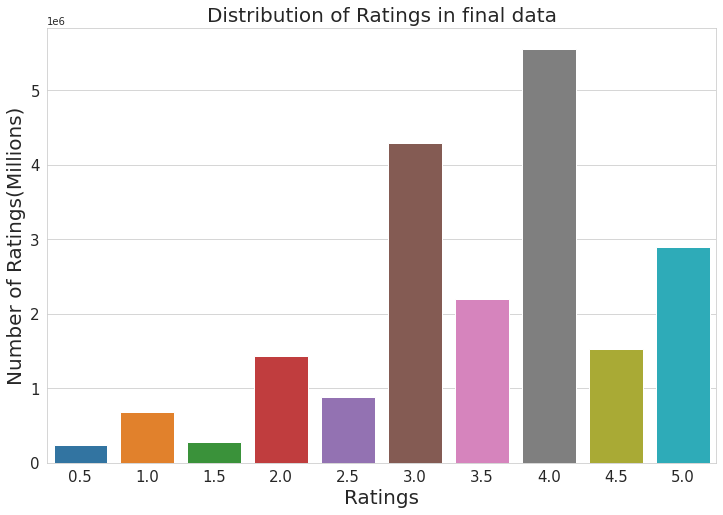

In [10]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize = (12, 8))
sns.countplot(x="rating", data=final_data)

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in final data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

In [11]:
print("Total number of movie ratings = "+str(final_data.shape[0]))
print("Number of unique users = "+str(len(np.unique(final_data["userId"]))))
print("Number of unique movies = "+str(len(np.unique(final_data["movieId"]))))

Total number of movie ratings = 20000263
Number of unique users = 138493
Number of unique movies = 26744


In [12]:
from sklearn.model_selection import train_test_split
#from surprise.model_selection import train_test_split
#train_data, test_data = train_test_split(final_data, test_size=.20)
train_data, test_data = train_test_split(final_data, test_size=0.20, random_state=30)

In [13]:
train_data.head()

,userId,movieId,rating,timestamp
19373917,134135,344,1.0,2014-08-03 07:29:44
7373284,50870,236,4.0,1996-11-16 13:38:36
992914,6713,47629,4.5,2008-10-30 19:55:19
1131221,7723,5512,3.0,2006-12-02 15:14:29
14921088,103088,1379,3.0,2008-07-10 23:31:30


In [14]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(train_data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(train_data["userId"]))))
print("Number of unique movies in train data = "+str(len(np.unique(train_data["movieId"]))))
print("Highest value of a User ID = "+str(max(train_data["userId"].values)))
print("Highest value of a Movie ID = "+str(max(train_data["movieId"].values)))

Total Train Data:
Total number of movie ratings in train data = 16000210
Number of unique users in train data = 138493
Number of unique movies in train data = 25886
Highest value of a User ID = 138493
Highest value of a Movie ID = 131262


In [15]:
test_data.head()

,userId,movieId,rating,timestamp
18832561,130456,6200,2.5,2003-06-08 20:09:59
9747289,67396,4056,1.0,2001-08-28 05:16:35
1178181,8053,4344,4.0,2001-07-21 00:37:54
14420448,99607,508,4.0,1996-07-18 13:31:08
2592728,17569,1722,1.0,1999-11-11 19:10:46


In [16]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(test_data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(test_data["userId"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(test_data["movieId"]))))
print("Highest value of a User ID = "+str(max(test_data["userId"].values)))
print("Highest value of a Movie ID = "+str(max(test_data["movieId"].values)))

Total Test Data:
Total number of movie ratings in Test data = 4000053
Number of unique users in Test data = 138318
Number of unique movies in Test data = 20290
Highest value of a User ID = 138493
Highest value of a Movie ID = 131260


In [17]:

no_of_rated_movies_per_user = train_data.groupby(by = "userId")["rating"].count().sort_values(ascending = False)
no_of_rated_movies_per_user.head()

userId
118205    7386
8405      6068
121535    4477
82418     4472
125794    4416
Name: rating, dtype: int64

In [18]:
no_of_rated_movies_per_user.describe()

count    138493.000000
mean        115.530821
std         184.276045
min           9.000000
25%          28.000000
50%          54.000000
75%         124.000000
max        7386.000000
Name: rating, dtype: float64

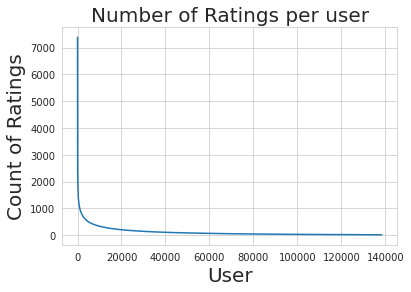

In [19]:
plt.title("Number of Ratings per user", fontsize = 20)
plt.xlabel("User", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_rated_movies_per_user.values)
plt.show()

In [20]:
no_of_ratings_per_movie = train_data.groupby(by = "movieId")["rating"].count().sort_values(ascending = False)
no_of_ratings_per_movie.head()

movieId
296    53814
356    52875
318    50494
593    50412
480    47842
Name: rating, dtype: int64

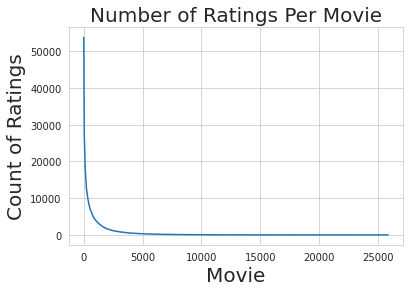

In [21]:

plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.show()

In [22]:
#user item sparse matrix

train_sparse_matrix = sparse.csr_matrix((train_data.rating, (train_data.userId, train_data.movieId)))
train_sparse_matrix.shape

(138494, 131263)

In [23]:
test_sparse_matrix = sparse.csr_matrix((test_data.rating, (test_data.userId, test_data.movieId)))
test_sparse_matrix.shape

(138494, 131261)

In [24]:
#If you can see above that the shape of both train and test sparse matrices are same, furthermore, how come this shape of sparse
#matrix has arrived:
#Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 
#Now the user whose user ID is highest is present in both train data and test data. Similarly, the movie whose movie ID is
#highest is present in both train data and test data. Hence, shape of both train and test sparse matrices are same.

rows,cols = train_sparse_matrix.shape
total_nonzero_element = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(total_nonzero_element/(rows*cols)))*100))

Sparsity Of Train matrix : 99.91198587045959% 


In [25]:
rows,cols = test_sparse_matrix.shape
total_nonzero_element = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(total_nonzero_element/(rows*cols)))*100))

Sparsity Of Test matrix : 99.97799612960063% 


In [26]:
#Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

In [27]:
#Global Average Rating in user item train sparse matrix

global_average_rating = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
global_average_rating

3.5255479771827996

In [28]:
#Average Rating Per User in user item train sparse matrix

average_rating_user = getAverageRatings(train_sparse_matrix, True)
average_rating_user[25]

3.6363636363636362

In [29]:
#Average Rating Per Movie in user item train sparse matrix

average_rating_movie = getAverageRatings(train_sparse_matrix, False)
average_rating_movie[4500]

3.7385892116182573

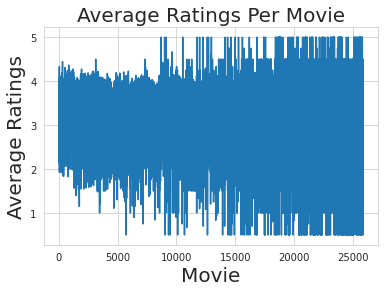

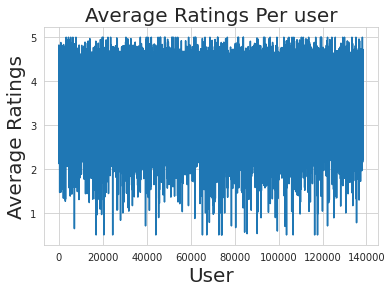

In [30]:
plt.title("Average Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Average Ratings", fontsize = 20)
movie_average=[avg for avg in average_rating_movie.values()]
plt.plot(movie_average)
plt.show()

plt.title("Average Ratings Per user", fontsize = 20)
plt.xlabel("User", fontsize = 20)
plt.ylabel("Average Ratings", fontsize = 20)
user_average=[avg for avg in average_rating_user.values()]
plt.plot(user_average)
plt.show()

In [31]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)   #this will give same random number everytime, without replacement
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])))
                                                    
    return sparse_sample

In [32]:
# creating sample sparse matrix for training data
train_sample_sparse = get_sample_sparse_matrix(train_sparse_matrix, 4000, 400)
train_sample_sparse.shape

(138440, 127631)

In [33]:

# creating sample sparse matrix for testing data
test_sample_sparse = get_sample_sparse_matrix(test_sparse_matrix, 2000, 200)
test_sample_sparse.shape

(138135, 95011)

In [34]:
#FEATURIZING FOR SAMPLE TRAIN DATA

In [35]:
# global average for a sample train data.
train_sample_averages = dict()
train_sample_global_averages = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
train_sample_averages['global'] = train_sample_global_averages
train_sample_averages['global']

3.5490377761938703

In [36]:
# Average ratings given by a user
train_sample_averages['movie'] = getAverageRatings(train_sample_sparse, False)
# Average ratings given by a movie
train_sample_averages['user'] = getAverageRatings(train_sample_sparse, True)

In [37]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

In [38]:
train_reg = pd.DataFrame()
for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = train_sample_sparse[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([train_sample_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = train_sample_sparse[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([train_sample_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(train_sample_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(train_sample_averages['user'][user])
            # Avg_movie rating
            row.append(train_sample_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            train_reg = train_reg.append([row])


In [39]:
train_reg.columns=['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
            'smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating']

In [40]:
train_reg.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,663,11,3.549038,3.5,4.0,2.0,4.0,4.0,3.0,3.0,1.000000,3.000000,5.000000,3.388889,3.671498,3.0
0,732,11,3.549038,3.0,4.0,4.0,4.0,4.0,3.5,2.5,3.666667,3.666667,3.666667,3.666667,3.671498,5.0
0,1754,11,3.549038,4.0,4.0,4.0,5.0,5.0,3.0,3.5,3.500000,3.500000,3.500000,3.500000,3.671498,4.0
0,1869,11,3.549038,4.0,4.0,5.0,4.0,4.0,2.0,4.0,2.000000,2.000000,2.800000,2.800000,3.671498,4.0
0,1937,11,3.549038,4.0,3.0,5.0,4.0,3.0,2.0,4.0,4.000000,3.000000,5.000000,3.833333,3.671498,3.0


In [41]:
#FEATURIZING FOR SAMPLE TEST DATA

In [42]:
# global average for a sample test data.
test_sample_averages = dict()
test_sample_global_averages = test_sample_sparse.sum()/test_sample_sparse.count_nonzero()
test_sample_averages['global'] = test_sample_global_averages
test_sample_averages['global']

3.347826086956522

In [43]:
# Average ratings given by a user
test_sample_averages['movie'] = getAverageRatings(test_sample_sparse, False)
# Average ratings given by a movie
test_sample_averages['user'] = getAverageRatings(test_sample_sparse, True)

In [44]:
# get users, movies and ratings from our samples test sparse matrix
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

In [45]:
test_reg = pd.DataFrame()
for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(test_sample_sparse[user], test_sample_sparse).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = test_sample_sparse[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([test_sample_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(test_sample_sparse[:,movie].T, test_sample_sparse.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = test_sample_sparse[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([test_sample_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(test_sample_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(test_sample_averages['user'][user])
            # Avg_movie rating
            row.append(test_sample_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            test_reg = test_reg.append([row])


In [46]:
test_reg.columns=['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
            'smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating']

In [47]:
test_reg.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,26590,9,3.347826,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.458333,4.0
0,31383,9,3.347826,4.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.458333,3.0
0,43399,9,3.347826,4.0,3.0,3.5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.458333,3.0
0,54959,9,3.347826,3.0,3.0,3.0,3.5,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.458333,4.0
0,57049,9,3.347826,4.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.458333,3.0


In [48]:
#User_ID: ID of a this User

#Movie_ID: ID of a this Movie

#Global_Average: Global Average Rating

#Ratings given to this Movie by top 5 similar users with this User: (SUR1, SUR2, SUR3, SUR4, SUR5)

#Ratings given by this User to top 5 similar movies with this Movie: (SMR1, SMR2, SMR3, SMR4, SMR5)

#User_Average: Average Rating of this User

#Movie_Average: Average Rating of this Movie

#Rating: Rating given by this User to this Movie

In [49]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [50]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    #All variable assignments in a function store the value in the local symbol table; whereas variable references first look 
    #in the local symbol table, then in the global symbol table, and then in the table of built-in names. Thus, global variables 
    #cannot be directly assigned a value within a function (unless named in a global statement), 
    #although they may be referenced.
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

In [51]:
# Surprise model 

In [52]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(train_reg[['user', 'movie', 'rating']], reader)

trainset = data.build_full_trainset()

In [53]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(test_reg[['user', 'movie', 'rating']], reader)

testset = data.build_full_trainset()

In [54]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

In [55]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [56]:
def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    train = dict()
    test = dict()
    
    algo.fit(trainset)

    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
    print("TEST DATA")
    test_pred = algo.test(testset.build_testset())
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}

    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

In [57]:
# For SVD

In [58]:
parameter  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   
# n_factors is the equivalent to dimension 'd' when matrix 'A' is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and d*m.
gs = GridSearchCV(SVD, parameter, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
print(gs.best_params['rmse'])

{'n_factors': 25}


In [59]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, random_state=15, verbose=True)
train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
TRAIN DATA
RMSE = 0.7864216051996965
MAPE = 26.30613640940337
TEST DATA
RMSE = 1.1114859202749359
MAPE = 48.84653264949965
Time Taken = 0:00:00.287783


In [60]:
# For SVDpp

In [61]:
parameter = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}
# lr_all means learning_rate
gs = GridSearchCV(SVDpp, parameter, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

{'n_factors': 10, 'lr_all': 0.018}


In [62]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'],random_state=15,lr_all = gs.best_params['rmse']["lr_all"], verbose=True)
train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
TRAIN DATA
RMSE = 0.40367419557158774
MAPE = 12.2833540773892
TEST DATA
RMSE = 1.111079652017906
MAPE = 48.72415892404071
Time Taken = 0:00:01.236109


In [63]:

train_reg["SVD"] = model_train_evaluation["SVD"]['Prediction']
train_reg["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

test_reg["SVD"] = model_test_evaluation["SVD"]["Prediction"]
test_reg["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]


In [64]:
train_reg.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,SVD,SVDpp
0,663,11,3.549038,3.5,4.0,2.0,4.0,4.0,3.0,3.0,1.000000,3.000000,5.000000,3.388889,3.671498,3.0,3.334451,3.601526
0,732,11,3.549038,3.0,4.0,4.0,4.0,4.0,3.5,2.5,3.666667,3.666667,3.666667,3.666667,3.671498,5.0,3.442776,2.950054
0,1754,11,3.549038,4.0,4.0,4.0,5.0,5.0,3.0,3.5,3.500000,3.500000,3.500000,3.500000,3.671498,4.0,3.817110,4.359684
0,1869,11,3.549038,4.0,4.0,5.0,4.0,4.0,2.0,4.0,2.000000,2.000000,2.800000,2.800000,3.671498,4.0,3.618519,3.342691
0,1937,11,3.549038,4.0,3.0,5.0,4.0,3.0,2.0,4.0,4.000000,3.000000,5.000000,3.833333,3.671498,3.0,3.088016,2.736114


In [65]:
test_reg.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,SVD,SVDpp
0,26590,9,3.347826,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.458333,4.0,3.549038,3.549038
0,31383,9,3.347826,4.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.458333,3.0,3.549038,3.549038
0,43399,9,3.347826,4.0,3.0,3.5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.458333,3.0,3.549038,3.549038
0,54959,9,3.347826,3.0,3.0,3.0,3.5,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.458333,4.0,3.549038,3.549038
0,57049,9,3.347826,4.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.458333,3.0,3.549038,3.549038


In [66]:
error_table=error_table.drop(['Train MAPE','Test MAPE'],axis=1)

In [67]:
error_table

,Model,Train RMSE,Test RMSE
0,SVD,0.786422,1.111486
1,SVDpp,0.403674,1.111080


In [68]:
# if rmse value<2 than we can say that it is good model. in this case svdpp is best model for matrix factorization recommendation system.